In [1]:
# Imports y carga de datos
import pandas as pd
from plotnine import *

# Ruta al CSV (ajusta si lo necesitas)
PATH_CSV = "f1_master_data_v3.csv"

df = pd.read_csv(PATH_CSV)

# Aseguramos tipos básicos
df['year'] = df['year'].astype(int)
df['round'] = df['round'].astype(int)

# Mapa de colores por equipo "principal"
TEAM_COLORS = {
    "Ferrari":       "#DC0000",  # rojo Ferrari
    "Mercedes":      "#00D2BE",  # turquesa Mercedes
    "Red Bull":      "#1E41FF",  # azul Red Bull
    "McLaren":       "#FF8700",  # naranja McLaren
    "Alpine F1 Team":"#2293D1",  # azul Alpine
    "Aston Martin":  "#006F62",  # verde Aston
    "Williams":      "#005AFF",  # azul Williams
}

def get_team_color(team_name: str) -> str:
    if pd.isna(team_name):
        return "lightgrey"
    for key, color in TEAM_COLORS.items():
        if key in str(team_name):
            return color
    return "lightgrey"


## **1** Heatmap: parrilla vs resultado (la remontada)

**Pregunta:**  
> ¿Cómo se relaciona la posición de salida con la posición final, y en qué zonas de la parrilla se concentran más las remontadas o las pérdidas de puestos?

**Tipo de gráfico elegido:**  
**Heatmap de densidad** en una cuadrícula `grid` × `positionOrder` (limitada a posiciones 1–20) con una línea diagonal de referencia `x = y`.

En lugar de mirar cada carrera como un punto aislado, el heatmap resume **cuántas veces** se ha dado cada combinación “salgo en X, termino en Y”. Esto facilita ver patrones globales de comportamiento.

**Canales visuales:**

- **Posición X:** posición de salida en parrilla (`grid_int`), de 1 a 20.  
- **Posición Y:** posición final (`pos_int` = `positionOrder`), también de 1 a 20, con el eje **invertido** para que P1 aparezca arriba (coherente con la idea de “mejor posición = más arriba”).  
- **Área / celda (tile):** cada cuadrado representa una combinación concreta de salida y resultado.  
- **Color de relleno (intensidad):** número de casos para esa combinación (`count`).  
  Cuanto más oscuro, más veces ha ocurrido “salió en X y acabó en Y”. La escala se recorta con un percentil (por ejemplo, 99) para que no se queme por un solo valor extremo y se aproveche bien la gama de tonos.  
- **Línea diagonal `x = y`:** referencia visual clave:  
  - Celdas **sobre** la diagonal → acabar peor de lo que se sale (pérdida de posiciones).  
  - Celdas **bajo** la diagonal → acabar mejor de lo que se sale (remontadas).  
  - Celdas **en** la diagonal → mantener la posición.

**Limitaciones y alternativa:**  
El heatmap **sintetiza muy bien el patrón global** y dónde se concentran las situaciones típicas (por ejemplo, cuántas veces se mantiene la pole, cuántas remontadas hay saliendo desde media parrilla, etc.). Sin embargo:

- No permite ver **casos individuales extremos** (cada punto concreto se “diluye” en la celda).  
- No distingue entre pilotos ni equipos, solo muestra el comportamiento agregado del campeonato.

**Alternativas:**

- Un **scatter plot** con puntos individuales y la diagonal `x = y` sería mejor para destacar outliers y carreras concretas, pero se vuelve muy denso con muchos años de datos.  
- **Boxplots de posición final por posición de salida** permitirían ver la distribución típica al salir desde P1, P2, etc., aunque perderías la visión conjunta de todo el espacio grid × resultado.


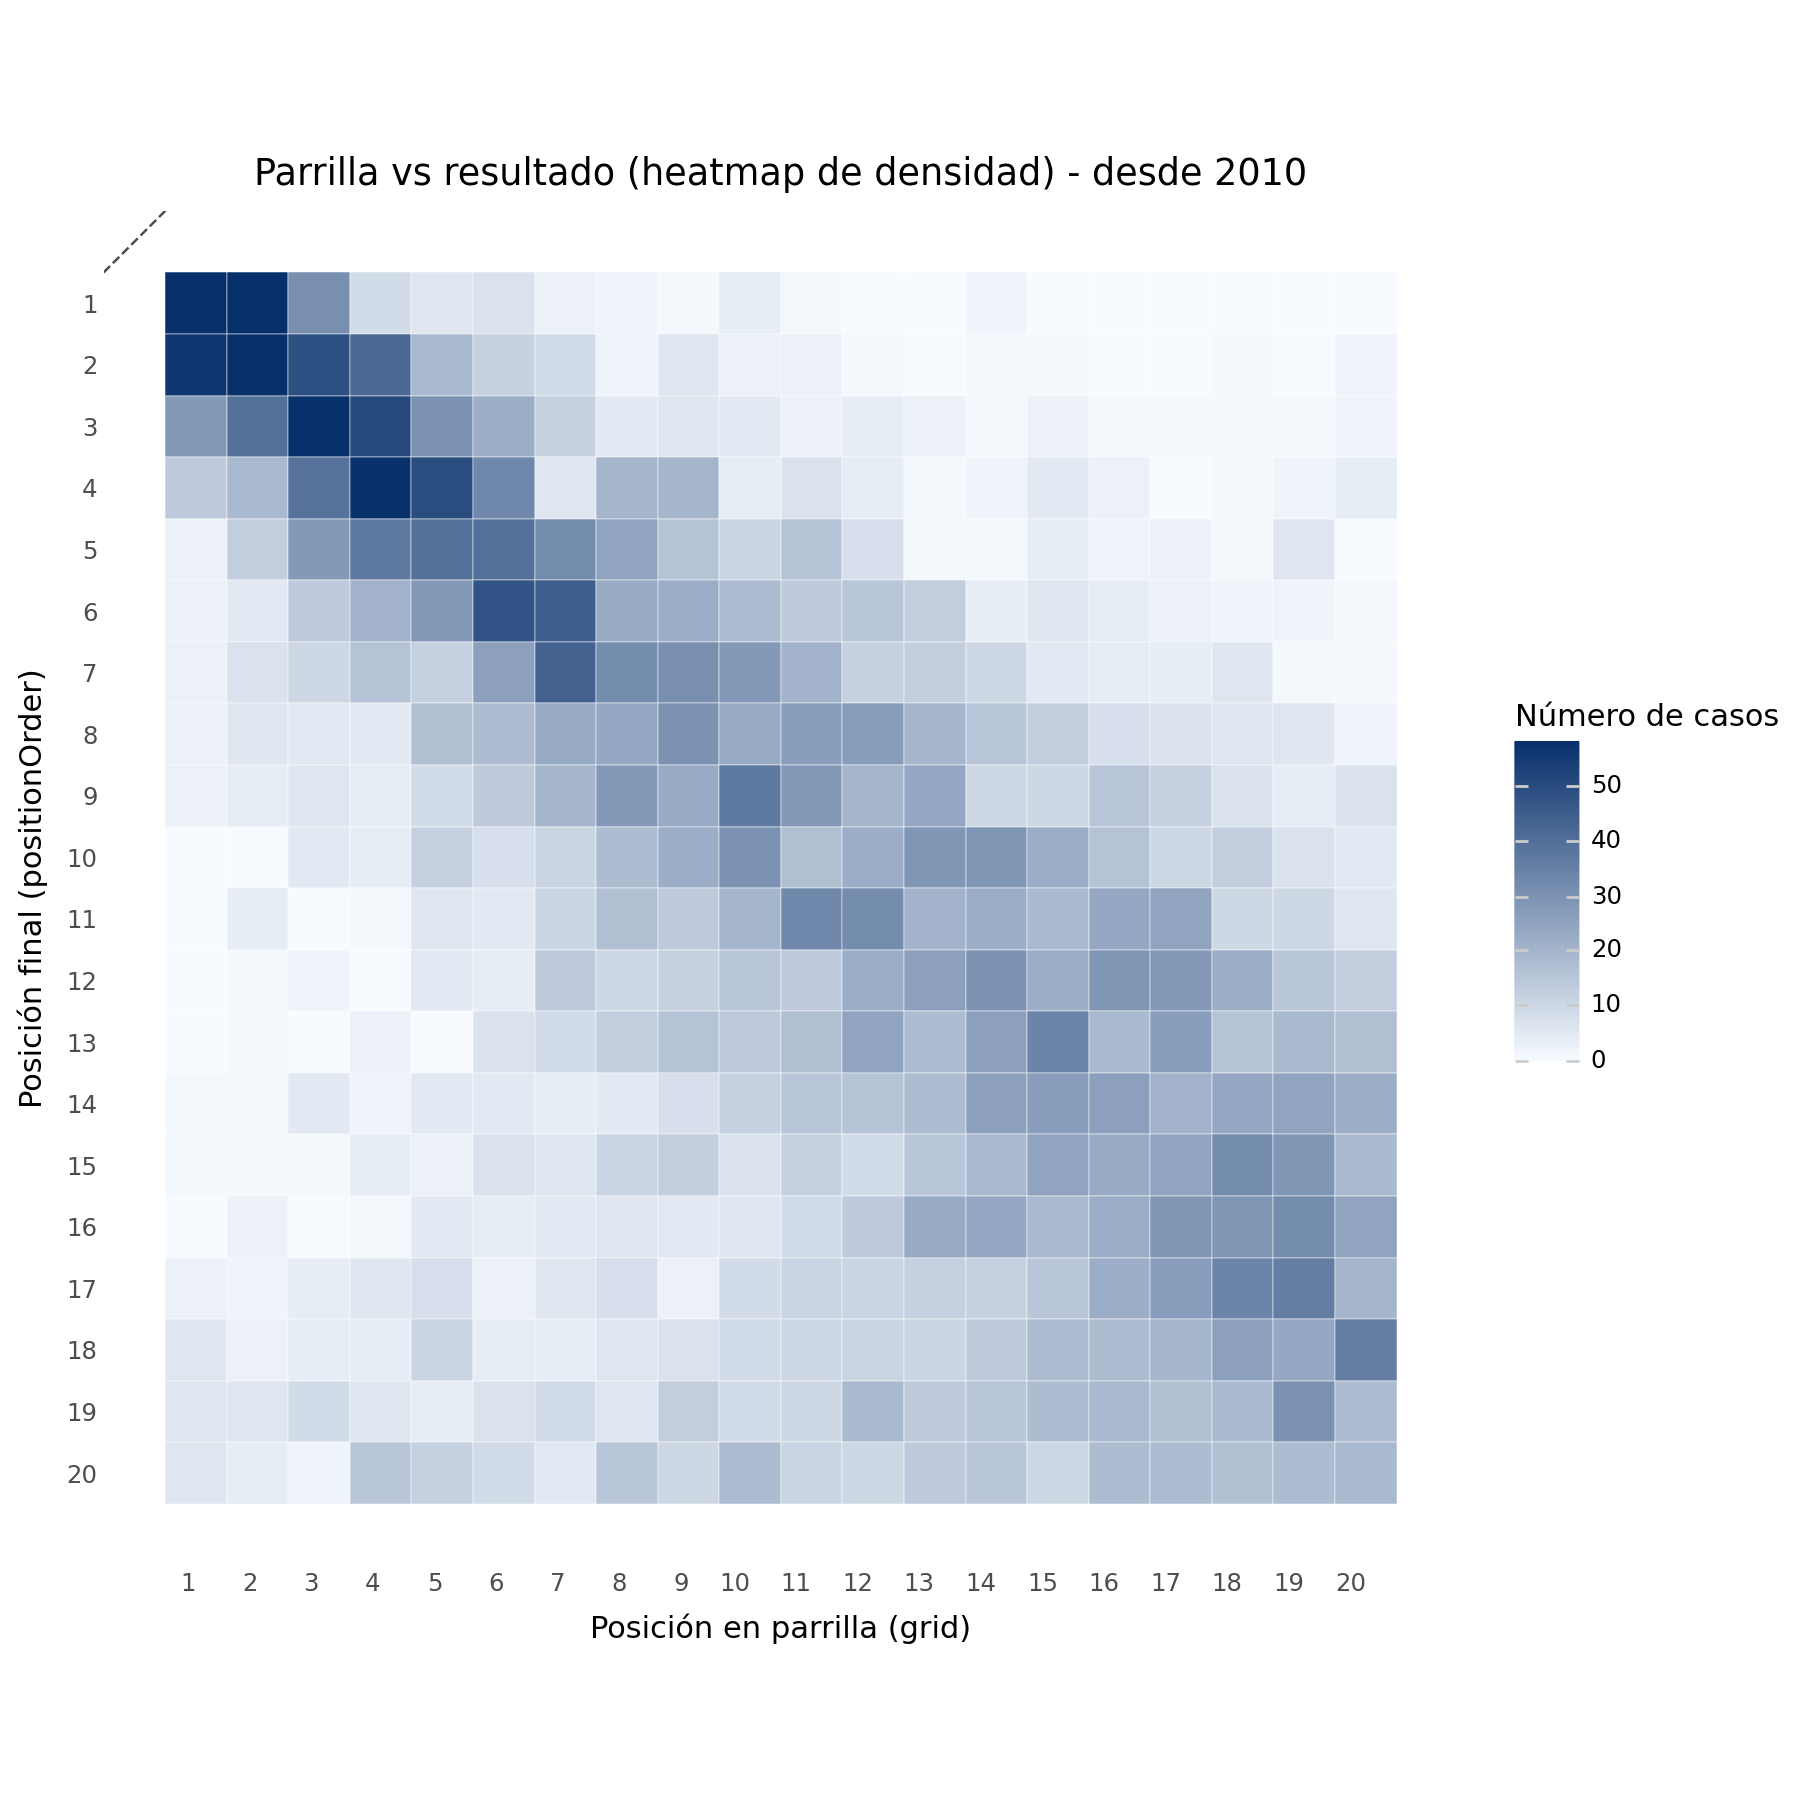

In [2]:
year_min = 2010  # filtrar años recientes

# 1) Filtrar y limpiar datos base
data = (
    df[df['year'] >= year_min]
    .dropna(subset=['grid', 'positionOrder'])
    .query('0 < grid <= 30 and 0 < positionOrder <= 30')
    .copy()
)

max_show = 20
data['grid_int'] = data['grid'].astype(int)
data['pos_int'] = data['positionOrder'].astype(int)

data_heat = data.query('grid_int <= @max_show and pos_int <= @max_show')

# 2) Tabla agregada: cuántas veces se da cada (grid, posición final)
heat_df = (
    data_heat
    .groupby(['grid_int', 'pos_int'])
    .size()
    .reset_index(name='count')
)

# 3) Cuadrícula completa 1..max_show x 1..max_show
full_index = pd.MultiIndex.from_product(
    [range(1, max_show + 1), range(1, max_show + 1)],
    names=['grid_int', 'pos_int']
)
full_grid = full_index.to_frame(index=False)

heat_df = full_grid.merge(heat_df, on=['grid_int', 'pos_int'], how='left')
heat_df['count'] = heat_df['count'].fillna(0)

# 4) Ajustar escala de color para que no se queme por outliers
max_visible = heat_df['count'].quantile(0.99)
if max_visible == 0:
    max_visible = heat_df['count'].max() if heat_df['count'].max() > 0 else 1

p_heat = (
    ggplot(heat_df, aes(x='grid_int', y='pos_int', fill='count')) +
    geom_tile(color='white') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='black', alpha=0.7) +
    scale_y_reverse(
        limits=(max_show + 0.5, 0.5),
        breaks=range(1, max_show + 1)
    ) +
    scale_x_continuous(
        limits=(0.5, max_show + 0.5),
        breaks=range(1, max_show + 1)
    ) +
    scale_fill_gradient(
        name='Número de casos',
        low='#f7fbff',
        high='#08306b',
        limits=(0, max_visible)
    ) +
    coord_equal() +
    labs(
        title=f'Parrilla vs resultado (heatmap de densidad) - desde {year_min}',
        x='Posición en parrilla (grid)',
        y='Posición final (positionOrder)'
    ) +
    theme_minimal() +
    theme(
        figure_size=(9, 9),
        axis_text_x=element_text(ha='right'),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank()
    )
)

p_heat

## **2** Boxplot: consistencia de los pilotos en una temporada

**Pregunta:**  
> ¿Qué pilotos son más consistentes en sus resultados de carrera a lo largo de una temporada?

**Tipo de gráfico elegido:**  
**Boxplot** de la posición final por piloto (para los pilotos top en puntos).

**Canales visuales:**

- **Posición X:** piloto (categoría).
- **Posición Y:** posición final en carrera (`positionOrder`), eje invertido para que las mejores posiciones estén arriba.
- **Altura de la caja (IQR):** indica la dispersión típica de resultados → consistencia.
- **Línea de la mediana:** posición “típica” del piloto.
- **Bigotes / outliers:** resultados extremadamente buenos o malos.

**Limitaciones y alternativa:**  
El boxplot resume muy bien la distribución, pero no muestra la secuencia temporal (cuándo ocurrieron las buenas o malas carreras).  
Una alternativa es un **jitter plot** (puntos individuales por carrera) con una línea de tendencia por piloto, que muestra todos los resultados a costa de ser más caótico.


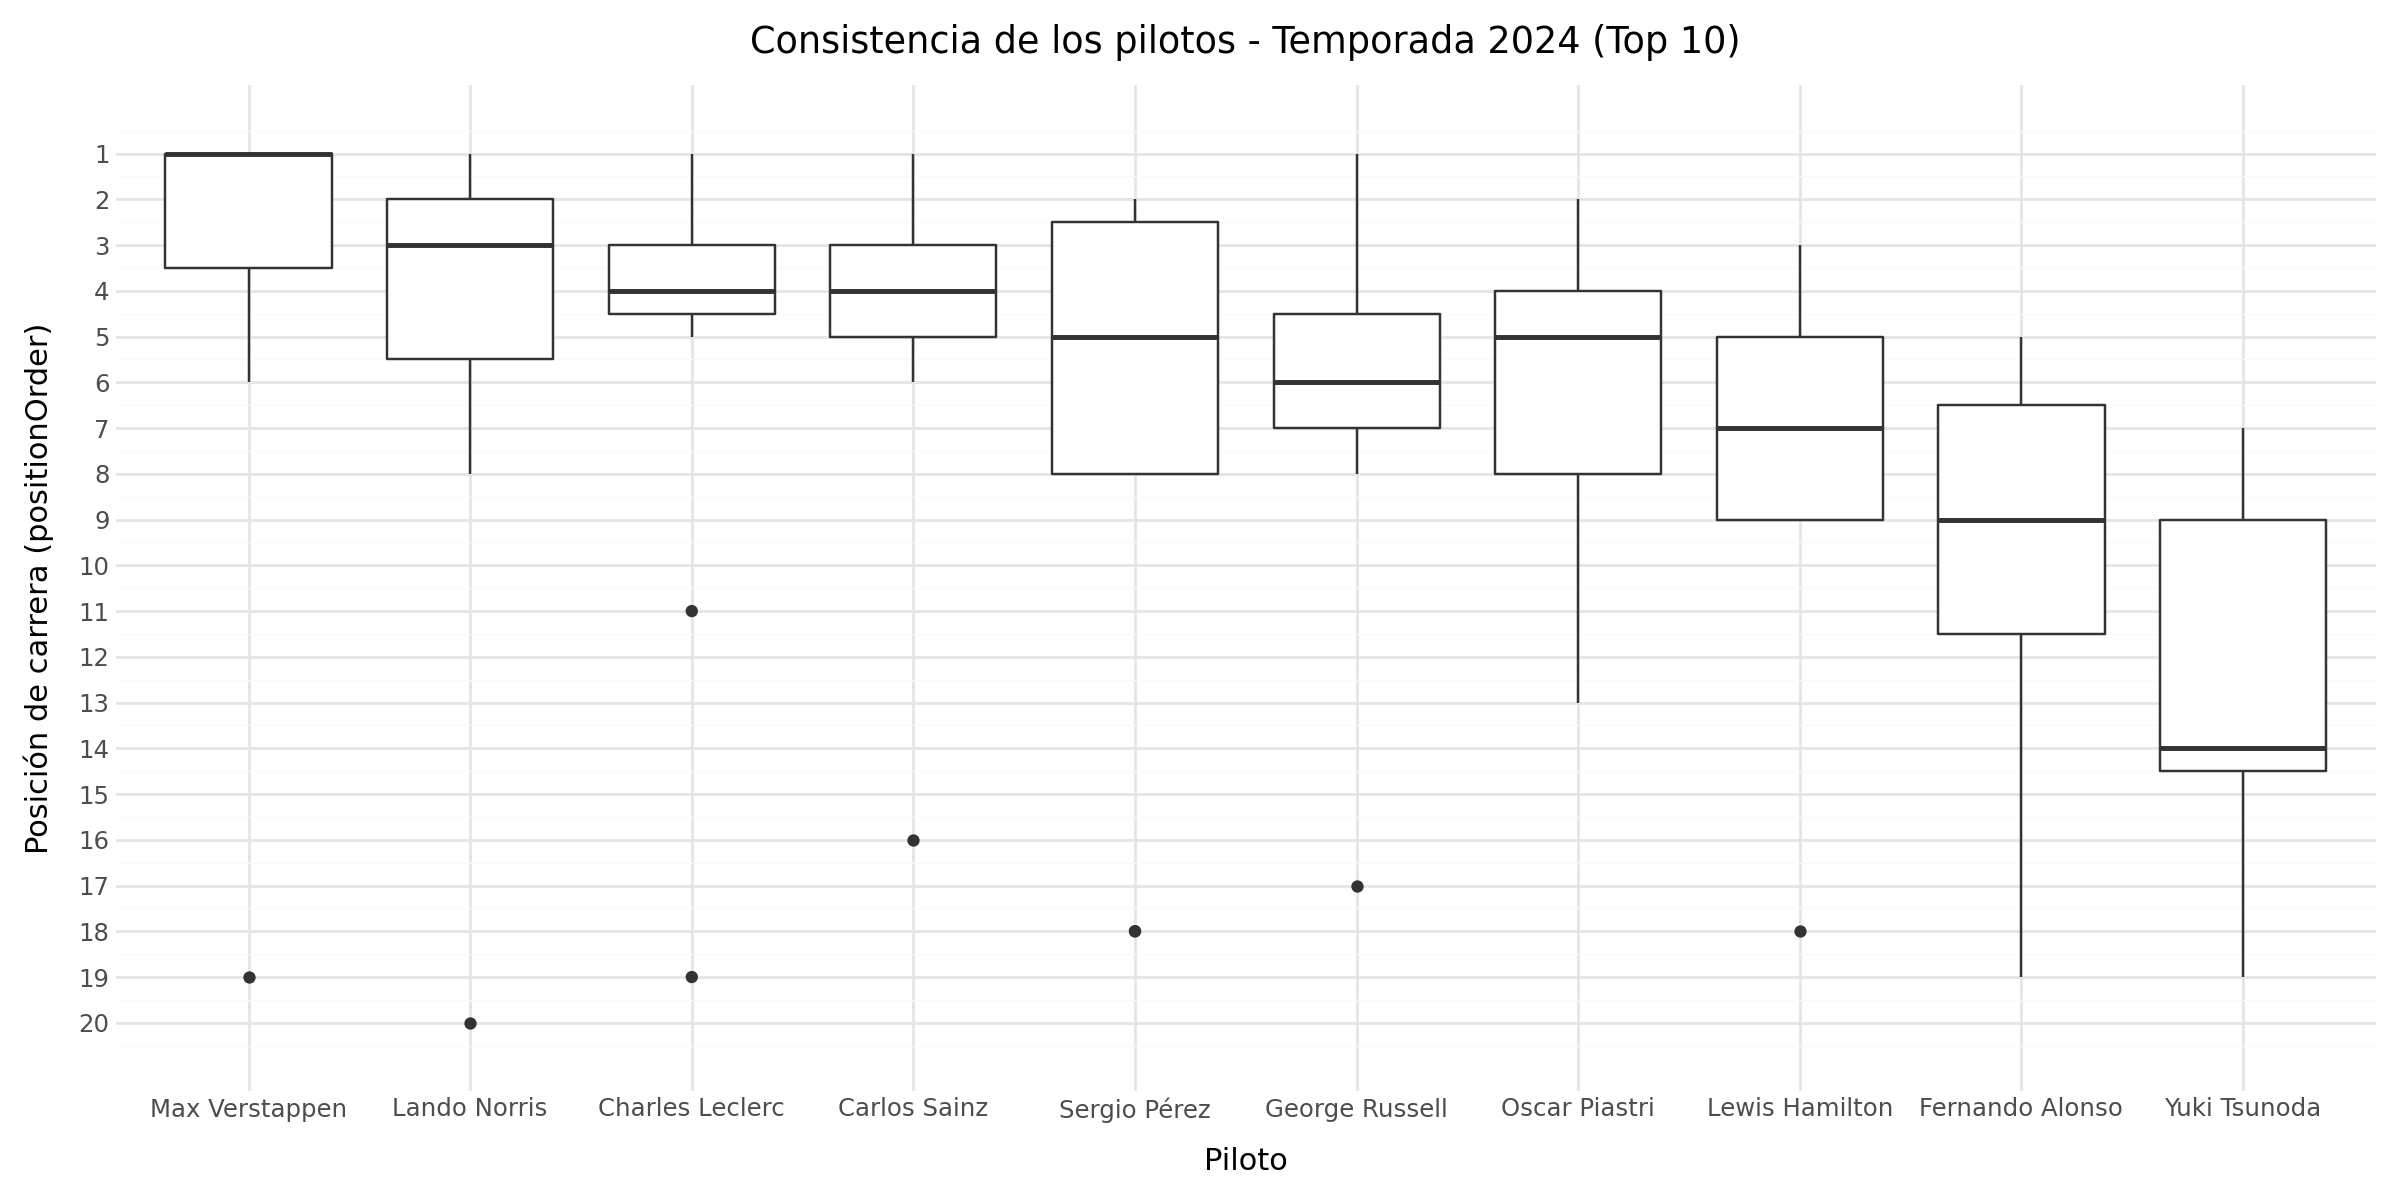

In [4]:
# 5) Consistencia de los pilotos (boxplot)

season = 2024  # temporada a analizar
top_n = 10     # top N pilotos por puntos

season_df = df[df['year'] == season].copy()

# Puntos totales por piloto
total_points = (
    season_df
    .groupby('driver_full_name')['points']
    .sum()
    .reset_index()
    .sort_values('points', ascending=False)
)

top_drivers = total_points.head(top_n)['driver_full_name']

consistency_df = season_df[season_df['driver_full_name'].isin(top_drivers)].copy()
consistency_df = consistency_df[
    (consistency_df['positionOrder'] > 0) &
    (~consistency_df['positionOrder'].isna())
]

# Mantener el orden de pilotos según puntos
consistency_df['driver_full_name'] = pd.Categorical(
    consistency_df['driver_full_name'],
    categories=top_drivers,
    ordered=True
)

max_show = 20  # mostramos de P1 a P20

from plotnine import *

p_box = (
    ggplot(consistency_df, aes(x='driver_full_name', y='positionOrder')) +
    geom_boxplot() +
    scale_y_reverse(
        limits=(max_show + 0.5, 0.5),
        breaks=range(1, max_show + 1)
    ) +
    labs(
        title=f'Consistencia de los pilotos - Temporada {season} (Top {top_n})',
        x='Piloto',
        y='Posición de carrera (positionOrder)'
    ) +
    theme_minimal() +
    theme(
        figure_size=(12, 6)
    )
)

p_box